# Pixtral: A Comparative Analysis of Vision Models

This notebook provides a structured and in-depth comparison of Pixtral, a cutting-edge vision model, against select peers such as Amazon Nova Pro, Anthropic’s Haiku 3 (excluding version 3.5) and Llama 3.2 11b. Our primary goal is to evaluate Pixtral’s performance, identify its strengths and limitations, and establish best practices for integrating Pixtral into workflows that demand accurate and efficient image understanding.

To achieve this, we will conduct a series of controlled tests and qualitative assessments, leveraging services like the Converse API, Amazon Bedrock, and a SageMaker inference endpoint for Pixtral. In addition to exploring model outputs on various image types—ranging from general object recognition tasks to financial document analysis and handwriting transcription—we will employ a judging model (Sonnet 3.5) to systematically evaluate and rank the quality of responses.

Through this process, the notebook will:

- Demonstrate how to efficiently use Pixtral’s endpoints for real-time inference.
- Compare Pixtral’s capabilities to other leading vision models using standardized prompts and test images.
- Help you understand the relative advantages of Pixtral, guiding you in deciding when and how to deploy it in your own applications.

We have included licensing details and quick-start references for further exploration. By the end of this analysis, you should have a clear perspective on Pixtral’s performance profile and actionable insights into optimizing its use in your specific scenarios.

All example outputs have been preserved in this notebook, allowing you to review the results without needing to run the code on your own instance or pay for compute costs. 

## Use

- **License:** Apache 2.0 - Pixtral

## Getting Started

The instructions for how to get started using this notebook can be found in the [Pixtral LMI notebook](https://github.com/aws-samples/mistral-on-aws/blob/59ab4ab9736122200a2d284039cb4557782e4a20/notebooks/Pixtral-samples/Pixtral-12b-LMI-SageMaker-realtime-inference.ipynb)

Want to learn more about Pixtral? [Check out the Pixtral_capabilities notebook](https://github.com/aws-samples/mistral-on-aws/blob/main/notebooks/Pixtral-samples/Pixtral_capabilities.ipynb)

In [ ]:
!pip install mistral_common[opencv] mistral_common=="v1.4.4" numpy==1.26.4 pypdfium2==4.30.1 --force --quiet

In [1]:
import re
import base64
import json
from PIL import Image
from io import BytesIO
from typing import List
import pypdfium2 as pdfium
from IPython.display import display, HTML

import boto3
import sagemaker
from sagemaker.djl_inference import DJLModel

# Colors to display information
RESET = "\033[0m"
GREEN = "\033[38;5;29m"
BLUE = "\033[38;5;43m"
ORANGE = "\033[38;5;208m"
PURPLE = "\033[38;5;93m"
RED = "\033[38;5;196m"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
bedrock_client = boto3.client('bedrock-runtime', region_name='us-west-2')

In [3]:
sess = sagemaker.Session() # sagemaker session for interacting with different AWS APIs

sagemaker_session_bucket = None # bucket to house artifacts
if sagemaker_session_bucket is None and sess is not None:
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role() # execution role for the endpoint
except ValueError:
    iam = boto3.client("iam")
    role = iam.get_role(RoleName="sagemaker_execution_role")["Role"]["Arn"]

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)
region = sess.boto_region_name
print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {region}")

sagemaker role arn: arn:aws:iam::597088022088:role/service-role/SageMaker-ExecutionRole-20241213T142162
sagemaker bucket: sagemaker-us-east-1-597088022088
sagemaker session region: us-east-1


In [4]:
image_uri =f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.30.0-lmi12.0.0-cu124" 

# You can also obtain the image_uri programatically as follows.
# image_uri = image_uris.retrieve(framework="djl-lmi", version="0.30.0", region="us-west-2")

model = DJLModel(
    role=role,
    image_uri=image_uri,
    env={
        "HF_MODEL_ID": "mistralai/Pixtral-12B-2409",
        "HF_TOKEN": "HF_Token", #since the model "mistralai/Pixtral-12B-2409" is gated model, you need a HF_TOKEN & go to https://huggingface.co/mistralai/Pixtral-12B-2409 to be granted access
        "OPTION_ENGINE": "Python",
        "OPTION_MPI_MODE": "true",
        "OPTION_ROLLING_BATCH": "lmi-dist",
        "OPTION_MAX_MODEL_LEN": "8192", # this can be tuned depending on instance type + memory available
        "OPTION_MAX_ROLLING_BATCH_SIZE": "16", # this can be tuned depending on instance type + memory available
        "OPTION_TOKENIZER_MODE": "mistral",
        "OPTION_ENTRYPOINT": "djl_python.huggingface",
        "OPTION_TENSOR_PARALLEL_DEGREE": "max",
        "OPTION_LIMIT_MM_PER_PROMPT": "image=4", # this can be tuned to control how many images per prompt are allowed
    }
)

In [5]:
predictor = model.deploy(instance_type="ml.g5.24xlarge", initial_instance_count=1)

In [6]:
def call_sagemaker_pdf_to_base64(file_path):
    pdf = pdfium.PdfDocument(file_path)
    images = []
    for page_index in range(len(pdf)):
        page = pdf[page_index]
        bitmap = page.render()
        images.append(bitmap)
    encoded_messages = []
    for i in range(len(images)):
        buffered = BytesIO()
        pil_image = images[i].to_pil()
        pil_image.save(buffered, format='PNG')
        img_byte = buffered.getvalue()
        base64_encoded = base64.b64encode(img_byte).decode('utf-8')
        encoded_messages.append({
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{base64_encoded}"
                }
            })
    return encoded_messages

def encode_image_to_data_url(image_path):
    """
    Reads an image from a local file path and encodes it to a data URL.
    """
    with open(image_path, 'rb') as image_file:
        image_bytes = image_file.read()
    base64_encoded = base64.b64encode(image_bytes).decode('utf-8')
    # Determine the image MIME type (e.g., image/jpeg, image/png)
    mime_type = Image.open(image_path).get_format_mimetype()
    data_url = f"data:{mime_type};base64,{base64_encoded}"
    return data_url

def send_images_to_model(predictor, prompt, image_paths):
    """
    Sends images and a prompt to the model and returns the response in plain text.
    """
    if isinstance(image_paths, str):
        image_paths = [image_paths]
    
    content_list = [{
        "type": "text",
        "text": prompt
    }]
    
    for image_path in image_paths:
        # Encode image to data URL
        if ".pdf" in image_path:
            content_list.extend(call_sagemaker_pdf_to_base64(image_path))
        else:
            data_url = encode_image_to_data_url(image_path)
            content_list.append({
                "type": "image_url",
                "image_url": {
                    "url": data_url
                }
                
            })
    
    payload = {
        "messages": [
            {
                "role": "user",
                "content": content_list
            }
        ],
        "max_tokens": 4000,
        "temperature": 0.1,
        "top_p": 0.9,
    }
    
    response = predictor.predict(payload)
    return response['choices'][0]['message']['content']

In [7]:
def get_image_format(image_path):
    with Image.open(image_path) as img:
        # Normalize the format to a known valid one
        fmt = img.format.lower() if img.format else 'jpeg'
        # Convert 'jpg' to 'jpeg'
        if fmt == 'jpg':
            fmt = 'jpeg'
    return fmt

def get_image_format(image_path):
    with Image.open(image_path) as img:
        # Normalize the format to a known valid one
        fmt = img.format.lower() if img.format else 'jpeg'
        # Convert 'jpg' to 'jpeg'
        if fmt == 'jpg':
            fmt = 'jpeg'
    return fmt

def call_bedrock_pdf_to_base64(file_path):
    pdf = pdfium.PdfDocument(file_path)
    images = []
    for page_index in range(len(pdf)):
        page = pdf[page_index]
        bitmap = page.render()
        images.append(bitmap)
    encoded_messages = []
    for i in range(len(images)):
        buffered = BytesIO()
        pil_image = images[i].to_pil()
        pil_image.save(buffered, format='PNG')
        img_byte = buffered.getvalue()
        encoded_messages.append({
            "image": {
                "format": "png",
                "source": {
                            "bytes": img_byte
                        }
            }
        })
    return encoded_messages

def call_bedrock_model(model_id=None, inference_arn=None, prompt="", image_paths=None, system_prompts=None, temperature=0.1, top_p=0.9, max_tokens=3000):
    if isinstance(image_paths, str):
        image_paths = [image_paths]
    if image_paths is None:
        image_paths = []
    if system_prompts is None:
        system_prompts = []

    # Start building the content array for the user message
    content_blocks = []

    # Include a text block if prompt is provided
    if prompt.strip():
        content_blocks.append({"text": prompt})

    # Add images as raw bytes
    for img_path in image_paths:
        if ".pdf" in img_path:
            content_blocks.extend(call_bedrock_pdf_to_base64(img_path))
        else:
            fmt = get_image_format(img_path)
            # Read the raw bytes of the image (no base64 encoding!)
            with open(img_path, 'rb') as f:
                image_raw_bytes = f.read()
    
            content_blocks.append({
                "image": {
                    "format": fmt,
                    "source": {
                        "bytes": image_raw_bytes
                    }
                }
            })

    # Construct the messages structure
    messages = [
        {
            "role": "user",
            "content": content_blocks
        }
    ]

    # Prepare additional kwargs if system prompts are provided
    kwargs = {}
    if system_prompts:
        kwargs["system"] = system_prompts

    # Build the arguments for the `converse` call
    converse_kwargs = {
        "messages": messages,
        "inferenceConfig": {
            "maxTokens": 4000,
            "temperature": temperature,
            "topP": top_p
        },
        **kwargs
    }

    # Use inferenceArn if provided, otherwise use modelId
    if inference_arn:
        converse_kwargs["inferenceArn"] = inference_arn
    else:
        converse_kwargs["modelId"] = model_id

    # Call the converse API
    try:
        response = bedrock_client.converse(**converse_kwargs)
    
        # Parse the assistant response
        assistant_message = response.get('output', {}).get('message', {})
        assistant_content = assistant_message.get('content', [])
        result_text = "".join(block.get('text', '') for block in assistant_content)
    except Exception as e:
        result_text = f"Error message: {e}"
    return result_text

Image being analyzed:


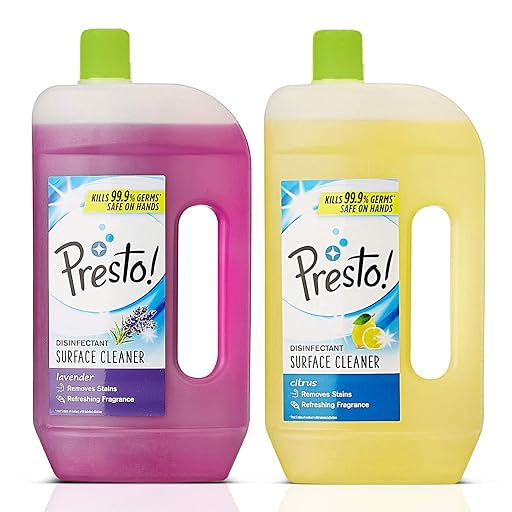



#### Amazon Nova Pro Response:
Two bottles of Presto! Disinfectant Surface Cleaner are placed on a white surface. The bottle on the left is lavender, and the bottle on the right is citrus. Both bottles have green caps and white labels with blue borders. The labels have the words "Presto!" and "Disinfectant Surface Cleaner" written on them. The bottles are filled with liquid, and the liquid is almost at the top of the bottles.
#### Claude Haiku Response:
The image shows two bottles of Presto! disinfectant surface cleaner. One bottle is pink in color with a lavender fragrance, while the other is yellow in color with a citrus fragrance. Both bottles prominently display the Presto! brand name and claim to kill 99.9% of germs on surfaces. The bottles appear to be household cleaning products intended for disinfecting and cleaning various surfaces.
#### Llama 3.2 11b Response:
The image features two bottles of Presto disinfectant surface cleaner, each with a distinct color and scent. The bo

In [10]:
from PIL import Image
import IPython.display as display

print("Image being analyzed:")
image_path = f"Pixtral_data/cleaner.jpg"
image = Image.open(image_path)
display.display(image)
print("\n")

prompt = "Describe this image in a short paragraph."

response_nova = call_bedrock_model(
    model_id="us.amazon.nova-pro-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Amazon Nova Pro Response:{RESET}")
print(f"{BLUE}{response_nova}{RESET}")

response_claude = call_bedrock_model(
    model_id="anthropic.claude-3-haiku-20240307-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Claude Haiku Response:{RESET}")
print(f"{RED}{response_claude}{RESET}")

response_llama = call_bedrock_model(
    model_id="us.meta.llama3-2-11b-instruct-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Llama 3.2 11b Response:{RESET}")
print(f"{PURPLE}{response_llama}{RESET}")

response_pixtral = send_images_to_model(
    predictor=predictor,
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Pixtral Response:{RESET}")
print(f"{ORANGE}{response_pixtral}{RESET}")

In the following step, we’ll use a LLM as a “judge” to compare the quality of each response. While this automated evaluation can offer valuable insights, it’s best supplemented with human judgment to ensure that the chosen response aligns with your specific goals. If all three outputs appear equally strong, your own criteria and preferences will guide the final decision.

For this demonstration, we’ll rely on Sonnet 3.5 as the judge. We’ll provide the original image and the three responses to determine which one emerges as the most accurate and helpful.

In [11]:
def evaluate_responses(image_path, nova_response, claude_response, llama_response, pixtral_response):
    evaluation_prompt = f"""Here is an image and three different AI models' descriptions of it. Please evaluate which model produced the best description and explain why.

Model A (Nova): {nova_response}

Model B (Claude): {claude_response}

Model C (Llama): {llama_response}

Model D (Pixtral): {pixtral_response}

Which model provided the best description? Please explain your reasoning and declare a winner."""

    judge_response = call_bedrock_model(
        model_id="anthropic.claude-3-5-sonnet-20241022-v2:0",
        prompt=evaluation_prompt,
        image_paths=image_path,
        temperature=0.1
    )
    print(f"{GREEN}Judge's Evaluation:{RESET}")
    print(f"{ORANGE}{judge_response}{RESET}")

In [12]:
evaluate_responses(
    image_path=image_path,
    nova_response=response_nova,
    claude_response=response_claude,
    llama_response=response_llama,
    pixtral_response=response_pixtral
)

Judge's Evaluation:
After analyzing all four descriptions, Model D (Pixtral) provided the best description for several reasons:

1. Accuracy and Detail:
- Correctly identified the colors (purple/lavender and yellow)
- Noted the green caps and side handles
- Accurately described the label content including "Kills 99.9% of germs" and "Removes stains"
- Mentioned the white background which is relevant for the image composition

2. Organization:
- Presented information in a logical flow
- Described both the physical attributes and functional aspects of the products
- Maintained good balance between detail and conciseness

3. Completeness:
While Models B and C also provided good descriptions, and Model A was accurate but brief, Model D managed to capture:
- Physical appearance
- Product features
- Label information
- Design elements
- Visual context (white background)

4. Clarity:
The description is easy to follow and gives readers a clear mental picture of what the products look like, even

## Analyzing a Financial Statement

Next, we’ll examine an Amazon financial document using all three models. Note that Llama 3.2’s image input must not exceed 1120 x 1120 in resolution, which requires us to provide a lower-resolution version of the document for Llama. By contrast, Pixtral and Haiku have no such image resolution constraints. This limitation provides an early indicator of where model selection might depend on input requirements.

Image being analyzed:


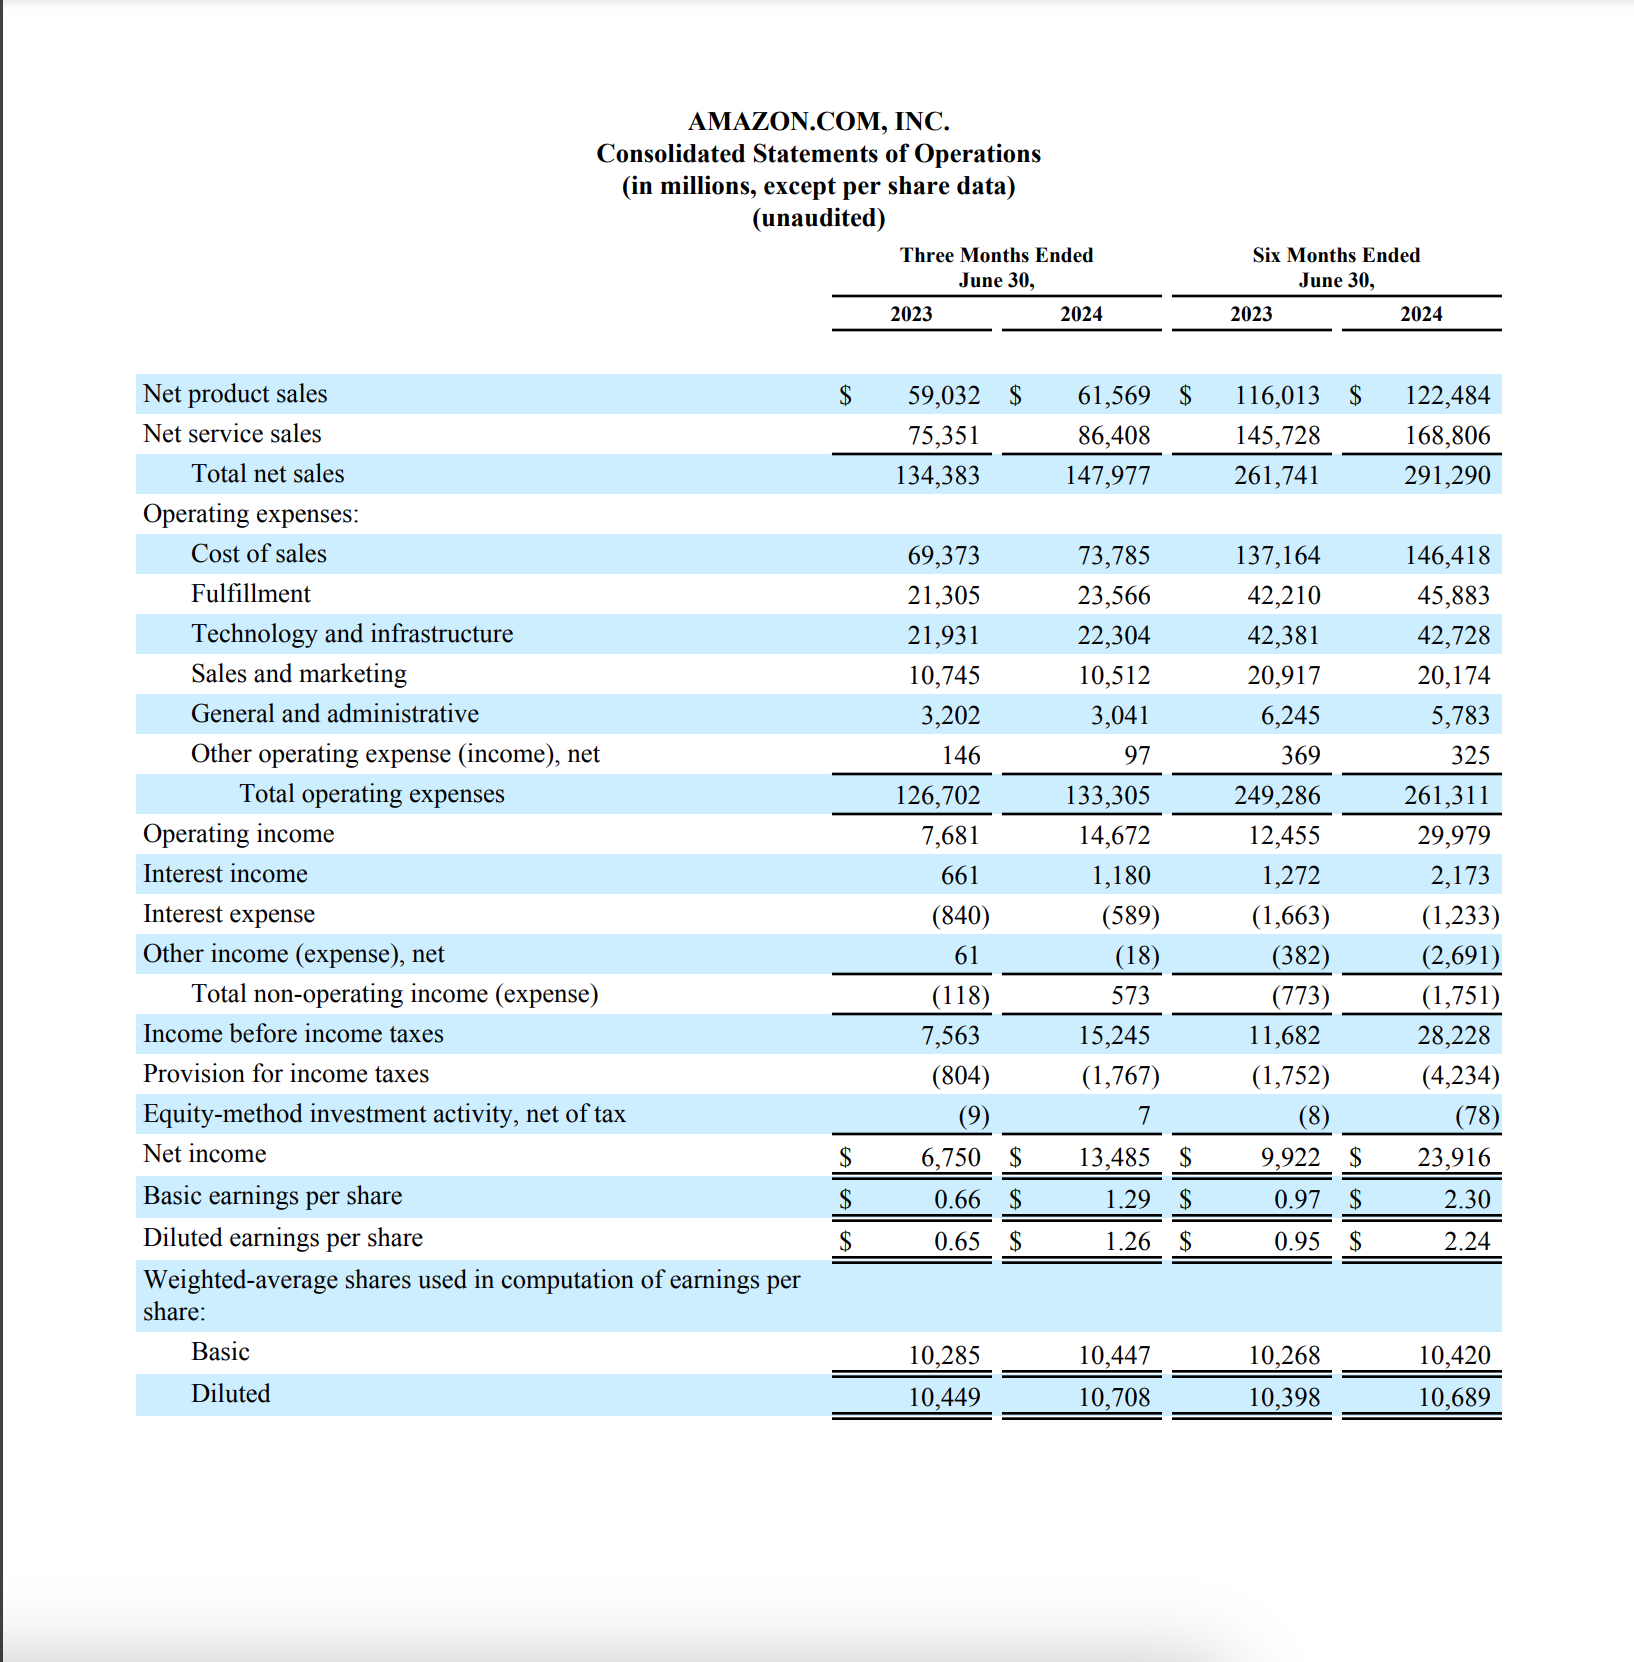



#### Amazon Nova Pro Response:
### Key Data

**Title:** Consolidated Statements of Operations

**Revenue:**
- Total net sales: $134,383 million (2023 Q2), $147,977 million (2024 Q2), $261,741 million (2023 YTD), $291,290 million (2024 YTD)

**Net income or loss:**
- Net income: $6,750 million (2023 Q2), $13,485 million (2024 Q2), $9,922 million (2023 YTD), $23,916 million (2024 YTD)

**Earnings per share (EPS):**
- Basic earnings per share: $0.66 (2023 Q2), $1.29 (2024 Q2), $0.97 (2023 YTD), $2.30 (2024 YTD)
- Diluted earnings per share: $0.65 (2023 Q2), $1.26 (2024 Q2), $0.95 (2023 YTD), $2.24 (2024 YTD)

**Operating expenses:**
- Total operating expenses: $126,702 million (2023 Q2), $133,305 million (2024 Q2), $249,286 million (2023 YTD), $261,311 million (2024 YTD)

**Significant one-time items or adjustments:**
- Equity-method investment activity, net of tax: $(9) million (2023 Q2), $7 million (2024 Q2), $(8) million (2023 YTD), $(78) million (2024 YTD)

**Diluted earnings per sh

In [13]:
from PIL import Image
import IPython.display as display

print("Image being analyzed:")
image_path = f"Pixtral_data/AMZN-Q2-2024-Earning-High-Quality.png"
image = Image.open(image_path)
display.display(image)
print("\n")

prompt = """Analyze the attached image of an earnings report.

Extract Key Data: Identify and summarize main financial metrics:

Title

Revenue
Net income or loss
Earnings per share (EPS)
Operating expenses
Significant one-time items or adjustments
Diluted earnings per share
Insights:

Evaluate overall financial health based on profitability, revenue growth, or cost management.
Note any risks or positive signals impacting future performance.
Conclusion: Provide a brief summary of the company’s performance this quarter, highlighting potential growth areas or concerns for investors. If specific data isn't present, then leave blank.
"""

response_nova = call_bedrock_model(
    model_id="us.amazon.nova-pro-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Amazon Nova Pro Response:{RESET}")
print(f"{BLUE}{response_nova}{RESET}")

response_claude = call_bedrock_model(
    model_id="anthropic.claude-3-haiku-20240307-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Claude Haiku Response:{RESET}")
print(f"{RED}{response_claude}{RESET}")

response_llama = call_bedrock_model(
    model_id="us.meta.llama3-2-11b-instruct-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Llama 3.2 11b Response:{RESET}")
print(f"{PURPLE}{response_llama}{RESET}")

response_pixtral = send_images_to_model(
    predictor=predictor,
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Pixtral Response:{RESET}")
print(f"{ORANGE}{response_pixtral}{RESET}")

In [14]:
evaluate_responses(
    image_path=image_path,
    nova_response=response_nova,
    claude_response=response_claude,
    llama_response=response_llama,
    pixtral_response=response_pixtral
)

Judge's Evaluation:
After analyzing all model descriptions, Model D (Pixtral) provided the best description of Amazon's financial statements for the following reasons:

1. Comprehensiveness: Model D offered the most complete breakdown of the financial data, including detailed categorization of revenue, net income, EPS, operating expenses, and one-time items/adjustments. It captured more granular details than the other models.

2. Organization: The information was clearly structured with distinct sections (Key Data Summary, Insights, and Conclusion), making it easy to follow and understand.

3. Additional Financial Metrics: Model D included important details about interest expense and other income/expense that were missing or less detailed in other models' descriptions.

4. Balanced Analysis: The insights section provided a well-rounded analysis of both positive trends (revenue growth, improved profitability) and potential concerns (operating expenses, interest expenses).

While Models 

## Handwriting Recognition

Image being analyzed:


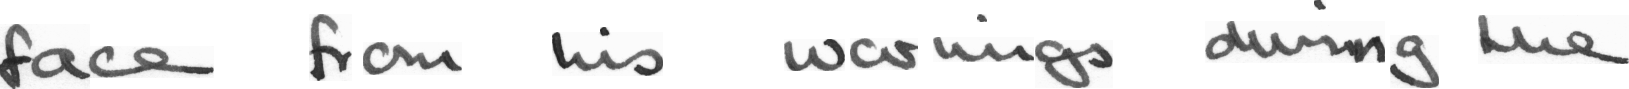



#### Amazon Nova Pro Response:
face how his was wrong dummg hue
#### Claude Haiku Response:
The handwritten text in the image says:

"face from his was wings during his"
#### Llama 3.2 11b Response:
Error message: An error occurred (ValidationException) when calling the Converse operation: The model returned the following errors: Image exceeds max pixels allowed.
#### Pixtral Response:
face from his waistings during the


In [15]:
from PIL import Image
import IPython.display as display

print("Image being analyzed:")
image_path = f"Pixtral_data/a01-082u-01.png"
image = Image.open(image_path)
display.display(image)
print("\n")

prompt = """Analyze the image and transcribe any handwritten text present.
Convert the handwriting into a single, continuous string of text.
Maintain the original spelling, punctuation, and capitalization as written.
Ignore any printed text, drawings, or other non-handwritten elements in the image."""

response_nova = call_bedrock_model(
    model_id="us.amazon.nova-pro-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Amazon Nova Pro Response:{RESET}")
print(f"{BLUE}{response_nova}{RESET}")

response_claude = call_bedrock_model(
    model_id="anthropic.claude-3-haiku-20240307-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Claude Haiku Response:{RESET}")
print(f"{RED}{response_claude}{RESET}")

response_llama = call_bedrock_model(
    model_id="us.meta.llama3-2-11b-instruct-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Llama 3.2 11b Response:{RESET}")
print(f"{PURPLE}{response_llama}{RESET}")

response_pixtral = send_images_to_model(
    predictor=predictor,
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Pixtral Response:{RESET}")
print(f"{ORANGE}{response_pixtral}{RESET}")

In [16]:
evaluate_responses(
    image_path=image_path,
    nova_response=response_nova,
    claude_response=response_claude,
    llama_response=response_llama,
    pixtral_response=response_pixtral
)

Judge's Evaluation:
Looking at the handwritten text in the image and comparing the four model descriptions:

Model B (Claude) provides the most professional and complete description by:
1. Clearly indicating that it's describing handwritten text
2. Presenting the text in a clear format
3. Attempting to transcribe the complete phrase

Model A's description is garbled and contains misspellings ("dummg", "hue").

Model C failed completely, returning only an error message.

Model D's transcription is close but lacks any context about it being handwritten text.

The actual text appears to read "face from his wastings during his" (though the handwriting is somewhat unclear).

WINNER: Model B (Claude)
Reason: It provided the most professional and structured response, properly framing the content as handwritten text, even though there might be slight variations in interpreting some of the handwritten words. The clear presentation and complete attempt at transcription makes it the most useful d

## Chart Analysis

Image being analyzed:


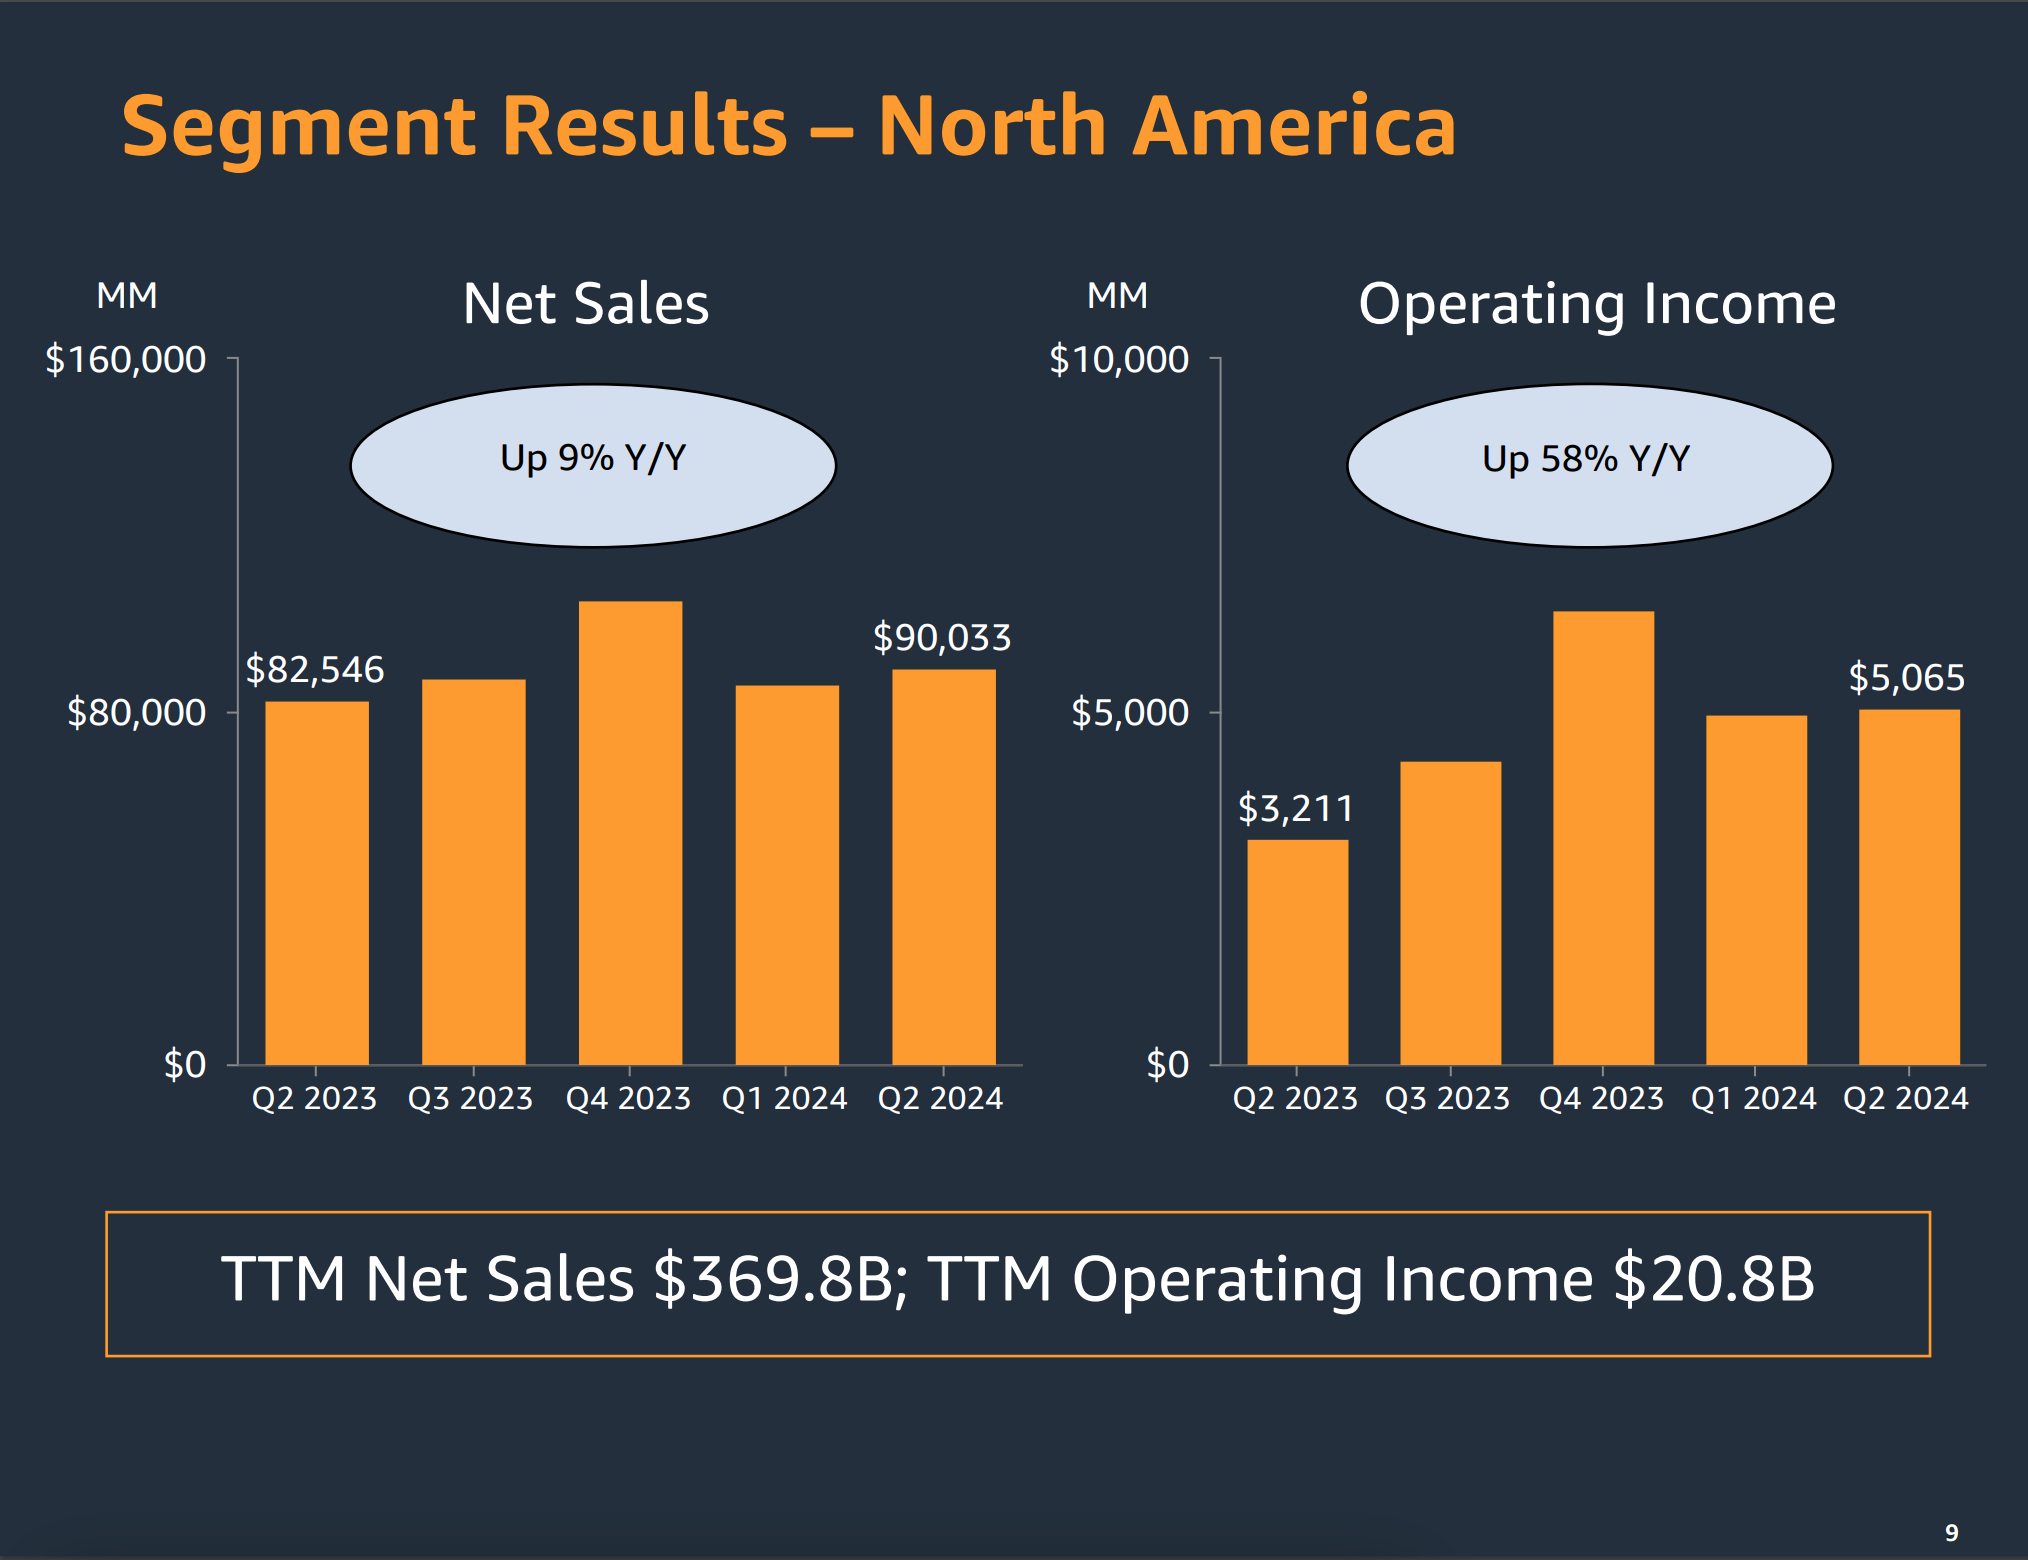



#### Amazon Nova Pro Response:
The image is a bar chart titled "Segment Results – North America," displaying two sets of data: Net Sales and Operating Income. The chart spans from Q2 2023 to Q2 2024, with each quarter represented by a bar. Net Sales are measured in millions of dollars (MM), with values ranging from $82,546 MM to $90,033 MM. Operating Income is also measured in millions of dollars, with values ranging from $3,211 MM to $5,065 MM. The chart highlights a 9% year-over-year (Y/Y) increase in Net Sales and a 58% Y/Y increase in Operating Income. The total transaction mix (TTM) for Net Sales is $369.8 billion, and for Operating Income, it is $20.8 billion. The main trend observed is a consistent increase in both Net Sales and Operating Income over the periods shown, indicating strong financial performance and growth in the North American segment.
#### Claude Haiku Response:
1. Type of chart or graph: The image presents a combination of a line graph for Net Sales and a bar c

In [17]:
from PIL import Image
import IPython.display as display

print("Image being analyzed:")
image_path = f"Pixtral_data/Amazon_Chart.png"
image = Image.open(image_path)
display.display(image)
print("\n")

prompt = """Analyze the attached image of the chart or graph. Your tasks are to:

Identify the type of chart or graph (e.g., bar chart, line graph, pie chart, etc.).
Extract the key data points, including labels, values, and any relevant scales or units.
Identify and describe the main trends, patterns, or significant observations presented in the chart.
Generate a clear and concise paragraph summarizing the extracted data and insights. The summary should highlight the most important information and provide an overview that would help someone understand the chart without seeing it.
Ensure that your summary is well-structured, accurately reflects the data, and is written in a professional tone.
"""

response_nova = call_bedrock_model(
    model_id="us.amazon.nova-pro-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Amazon Nova Pro Response:{RESET}")
print(f"{BLUE}{response_nova}{RESET}")

response_claude = call_bedrock_model(
    model_id="anthropic.claude-3-haiku-20240307-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Claude Haiku Response:{RESET}")
print(f"{RED}{response_claude}{RESET}")

response_llama = call_bedrock_model(
    model_id="us.meta.llama3-2-11b-instruct-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Llama 3.2 11b Response:{RESET}")
print(f"{PURPLE}{response_llama}{RESET}")

response_pixtral = send_images_to_model(
    predictor=predictor,
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Pixtral Response:{RESET}")
print(f"{ORANGE}{response_pixtral}{RESET}")

In [18]:
evaluate_responses(
    image_path=image_path,
    nova_response=response_nova,
    claude_response=response_claude,
    llama_response=response_llama,
    pixtral_response=response_pixtral
)

Judge's Evaluation:
After analyzing all descriptions, Model D (Pixtral) provided the best description of the image for several reasons:

1. Comprehensiveness: Model D offered the most complete analysis, including:
- Detailed breakdown of data points for both Net Sales and Operating Income
- Clear organization with sections for Key Data Points, Main Trends, and Summary
- Inclusion of TTM (Trailing Twelve Months) figures
- Proper context for all percentage changes

2. Accuracy: Model D's numbers closely matched the actual data shown in the chart, while Model B had some significant errors (like stating Q1 2024 Net Sales as $160,000 million, which is incorrect).

3. Structure: The description was well-organized with clear headers and sections, making it easy to follow and understand the information.

4. Balance: It provided both detailed data points and broader trend analysis, giving readers both specific figures and the bigger picture.

5. Professional Formatting: The use of bullet points

## Image Captioning



Image being analyzed:


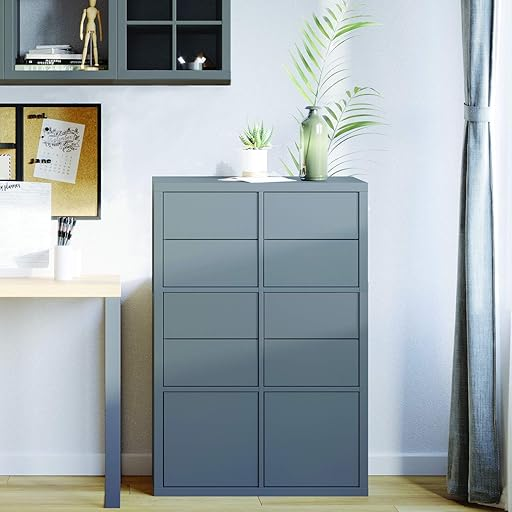



#### Amazon Nova Pro Response:
The image depicts a modern, minimalist office or study space. The main subject is a tall, gray storage cabinet with multiple drawers, positioned against a light-colored wall. The cabinet is sleek and contemporary, with a smooth surface and clean lines. On top of the cabinet, there is a small potted plant and a clear glass vase with a green plant inside, adding a touch of nature to the space.

To the left of the cabinet, there is a desk with a light-colored surface. On the desk, there is a bulletin board with various papers and notes pinned to it, indicating an organized workspace. The bulletin board is mounted on the wall, and there is a small shelf above it holding a figurine and some books.

The lighting in the room appears to be natural, coming from an unseen window, as suggested by the soft, diffused light. The overall mood is calm and orderly, with a focus on functionality and simplicity.

The spatial arrangement is well-organized, with the cabinet

In [19]:
from PIL import Image
import IPython.display as display

print("Image being analyzed:")
image_path = f"Pixtral_data/dresser.jpg"
image = Image.open(image_path)
display.display(image)
print("\n")

prompt = """Analyze the image and provide a detailed description of what you see. Include:

1. The main subject or focus of the image
2. Key elements or objects present
3. Colors, lighting, and overall mood
4. Spatial arrangement and composition
5. Any text or symbols visible
6. Actions or events taking place, if applicable
7. Background and setting details
8. Distinctive features or unusual aspects
9. Estimated time of day or season, if relevant
10. Overall context or type of scene (e.g., natural landscape, urban setting, indoor space)

Describe the image as if explaining it to someone who cannot see it. Be thorough but concise, focusing on the most important and interesting aspects of the image.
"""

response_nova = call_bedrock_model(
    model_id="us.amazon.nova-pro-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Amazon Nova Pro Response:{RESET}")
print(f"{BLUE}{response_nova}{RESET}")

response_claude = call_bedrock_model(
    model_id="anthropic.claude-3-haiku-20240307-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Claude Haiku Response:{RESET}")
print(f"{RED}{response_claude}{RESET}")

response_llama = call_bedrock_model(
    model_id="us.meta.llama3-2-11b-instruct-v1:0",
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Llama 3.2 11b Response:{RESET}")
print(f"{PURPLE}{response_llama}{RESET}")

response_pixtral = send_images_to_model(
    predictor=predictor,
    prompt=prompt,
    image_paths=image_path
)

print(f"{GREEN}#### Pixtral Response:{RESET}")
print(f"{ORANGE}{response_pixtral}{RESET}")

In [20]:
evaluate_responses(
    image_path=image_path,
    nova_response=response_nova,
    claude_response=response_claude,
    llama_response=response_llama,
    pixtral_response=response_pixtral
)

Judge's Evaluation:
After analyzing all four descriptions, I would rank Model A (Nova) as providing the best description of the image. Here's why:

1. Accuracy and Detail:
- Model A provides the most accurate and comprehensive description of all elements in the image, including precise details about the cabinet, desk, bulletin board, and decorative items.
- It correctly identifies the spatial relationships between objects and accurately describes the color scheme.

2. Organization and Flow:
- The description flows naturally from the main focal point (the cabinet) to surrounding elements, making it easy to visualize the scene.
- It maintains a logical structure while avoiding redundancy.

3. Contextual Understanding:
- Model A effectively captures the overall mood and style of the space, noting the "minimalist" and "contemporary" aspects.
- It provides relevant context about the purpose and function of the space.

4. Sensory Details:
- The description includes observations about lightin

## FSI: Insurance Form Data Extraction

In [ ]:
from IPython.display import IFrame
import IPython.display as display

# open PDF
pdf_path = f"Pixtral_data/insurance_90degree.pdf"
with open(pdf_path, "rb") as pdf:
    content = pdf.read()

# encode PDF
base64_pdf = base64.b64encode(content).decode("utf-8")

# display encoded PDF
print("PDF being analyzed:")
display.display(IFrame(f"data:application/pdf;base64,{base64_pdf}", width=1000, height=500))

prompt = """As a medical document analyzer, extract these fields from the insurance verification form and return as JSON:

Required fields:
- Patient name
- Date of birth 
- Policy number
- Insurance provider name
- Coverage start date
- Phone numbers (work/home)
- Subscriber name
- Group number
- Plan type (PPO/HMO)
- Verification date

Format the response as:
{
  'patient_info': {
    'name': string,
    'dob': string,
    'phone': {
      'work': string,
      'home': string
    }
  },
  'insurance_info': {
    'provider': string,
    'policy_number': string, 
    'group_number': string,
    'subscriber': string,
    'plan_type': string,
    'coverage_start': string,
    'verification_date': string
  }
}"""

response_nova = call_bedrock_model(
    model_id="us.amazon.nova-pro-v1:0",
    prompt=prompt,
    image_paths=pdf_path
)

print(f"{GREEN}#### Amazon Nova Pro Response:{RESET}")
print(f"{BLUE}{response_nova}{RESET}")

response_claude = call_bedrock_model(
    model_id="anthropic.claude-3-haiku-20240307-v1:0",
    prompt=prompt,
    image_paths=pdf_path
)

print(f"{GREEN}#### Claude Haiku Response:{RESET}")
print(f"{RED}{response_claude}{RESET}")

response_llama = call_bedrock_model(
    model_id="us.meta.llama3-2-11b-instruct-v1:0",
    prompt=prompt,
    image_paths=pdf_path
)

print(f"{GREEN}#### Llama 3.2 11b Response:{RESET}")
print(f"{PURPLE}{response_llama}{RESET}")

response_pixtral = send_images_to_model(
    predictor=predictor,
    prompt=prompt,
    image_paths=pdf_path
)

print(f"{GREEN}#### Pixtral Response:{RESET}")
print(f"{ORANGE}{response_pixtral}{RESET}")

PDF being analyzed:


#### Amazon Nova Pro Response:
```json
{
  "patient_info": {
    "name": "Toy Soper",
    "dob": "07/16/1979",
    "phone": {
      "work": "713-333-3333",
      "home": "713-333-3333"
    }
  },
  "insurance_info": {
    "provider": "Topper",
    "policy_number": "03/16/2024-S13",
    "group_number": "911-31-7199",
    "subscriber": "Toy Soper",
    "plan_type": "PPO",
    "coverage_start": "07/16/2024",
    "verification_date": "03/16/2024"
  }
}
```
#### Claude Haiku Response:
Here is the JSON response with the extracted fields from the insurance verification form:

{
  'patient_info': {
    'name': 'Patient Name: John Doe',
    'dob': '03/17/14',
    'phone': {
      'work': '555-1234',
      'home': '555-5678'
    }
  },
  'insurance_info': {
    'provider': 'Insurance Provider: ABC Insurance',
    'policy_number': '123456789',
    'group_number': 'Group No.: 12345',
    'subscriber': 'Subscriber: Jane Doe',
    'plan_type': 'PPO',
    'coverage_start': '01/01/14',
    'verificati

In [23]:
evaluate_responses(
    image_path=pdf_path,
    nova_response=response_nova,
    claude_response=response_claude,
    llama_response=response_llama,
    pixtral_response=response_pixtral
)

Judge's Evaluation:
Looking at the actual insurance verification form in the image and comparing it to the model descriptions, I can evaluate their accuracy:

Model C (Llama) appears to provide the most accurate description that matches the actual form shown in the image. Here's why:

1. Format: Model C presents the information in both a readable format and JSON structure, making it clear and well-organized.

2. Accuracy: The extracted information appears to closely match what's visible in the form, including details like:
- The name format matches the style shown
- The phone number format includes parentheses as shown in the form
- The dates and numbers appear to be consistent with what's visible in the image

3. Completeness: Model C captures all the relevant fields from the form while maintaining proper structure and organization.

The other models have various issues:
- Model A uses clearly fictional data that doesn't match the form
- Model B uses generic placeholder data (John/Jan

## Observations

Across multiple scenarios, the models—Nova, Claude Haiku, Llama 3.2, and Pixtral—demonstrated varying strengths and weaknesses. The evaluations were conducted with the assistance of a judging LLM (Sonnet 3.5), which assessed clarity, completeness, accuracy, and overall descriptive quality. The following summarizes the key observations from each test scenario:

**Household Cleaner Image:**

When describing two bottles of disinfectant surface cleaner, Pixtral’s response was judged superior. It provided a highly detailed, visually rich description, accurately capturing colors, branding elements, and design motifs that the other models overlooked. This suggests Pixtral’s strong capability for nuanced visual analysis of everyday objects.

**Financial Document Analysis:**

In the case of an Amazon financial statement image, Pixtral again excelled. It offered a well-structured, comprehensive breakdown of financial metrics and contextualized the company’s performance effectively. The model’s balanced approach—combining raw data extraction with insightful commentary—surpassed the more limited or less organized presentations from Claude and Llama.

**Handwriting Transcription:**

For handwriting recognition, none of the models performed perfectly. However, the judge deemed Claude’s response the least inaccurate, as it introduced fewer extraneous words compared to Llama and Pixtral. This scenario highlights a challenge for all tested models: accurately parsing handwritten text. While Claude edged ahead here, the overall quality from all three remained suboptimal. The author isn't entirely sure what the second to third to last word is. None of the models were correct, however, Claude did not introduce additional words while Pixtral and Llama did.

**Chart/Graph Interpretation:**

When analyzing a chart of North American segment results, Pixtral outperformed the others. It displayed an impressive level of detail, correctly interpreting data points, capturing year-over-year changes, and providing a clear, logical structure. The model’s ability to handle numeric data and present it contextually was a standout feature, reaffirming Pixtral’s strength in scenarios where clarity and thoroughness are paramount.

**Indoor Scene Description (Dresser Image):**

In describing a minimalist indoor space, Llama was selected as the winner. It provided granular detail, accurately noted subtle elements like a corkboard and shelf, and gave a clear sense of the environment’s purpose and ambiance. Although Pixtral and Claude produced competent descriptions, Llama’s richer detail and organization gave it the edge in this setting.

**Insurance Form Data Extraction:**

In analyzing medical insurance verification forms, Llama demonstrated a great performance by correctly identifying most information and maintaining proper JSON structure, while other models relied on generic placeholder data. Though Llama and Nova misinterpreted some information, their accurate field capture and standardized formatting outperformed Claude and Pixtral, highlighting both progress and persistent challenges in automated document processing.

### Overall Conclusions:

**Pixtral frequently delivered the most comprehensive and structured analyses, particularly for tasks requiring detailed, multi-level descriptions of data-rich images (e.g., financial statements, charts, and product details).** Its performance in these areas suggests that it is a strong candidate for use cases demanding thorough and accurate visual summarization.

Llama 3.2 excelled in capturing intricate details within certain contexts, as seen in the indoor scene description. Its strength appears to lie in careful observation and nuanced environmental portrayal, making it a good fit for tasks requiring a keen eye for subtle elements and layout.

Claude Haiku generally produced reasonable summaries but often lacked the depth or precision of the others. It performed best in the handwriting scenario, possibly due to simpler transcription logic relative to the errors the others introduced. While Claude’s descriptions are understandable and coherent, they may not always match the richer level of detail and analysis provided by Pixtral or Llama.

Nova excels at structured document processing, demonstrating superior performance in form data extraction through accurate field identification and JSON structuring. While showing limitations with dates and numbers, its performance indicates strong potential for document automation, fitting well within the broader ecosystem of specialized vision-language models.

In conclusion, all four models have their merits and shortcomings. Pixtral stands out for structured, data-heavy image analyses; Llama shines in scenario-based detail and compositional complexity; Nova excels at document processing and form data extraction; Claude is a steady if less detailed performer, excelling occasionally in simpler tasks like handwriting. Depending on the complexity of the use case and the type of image being processed, each model could be the right choice.